In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

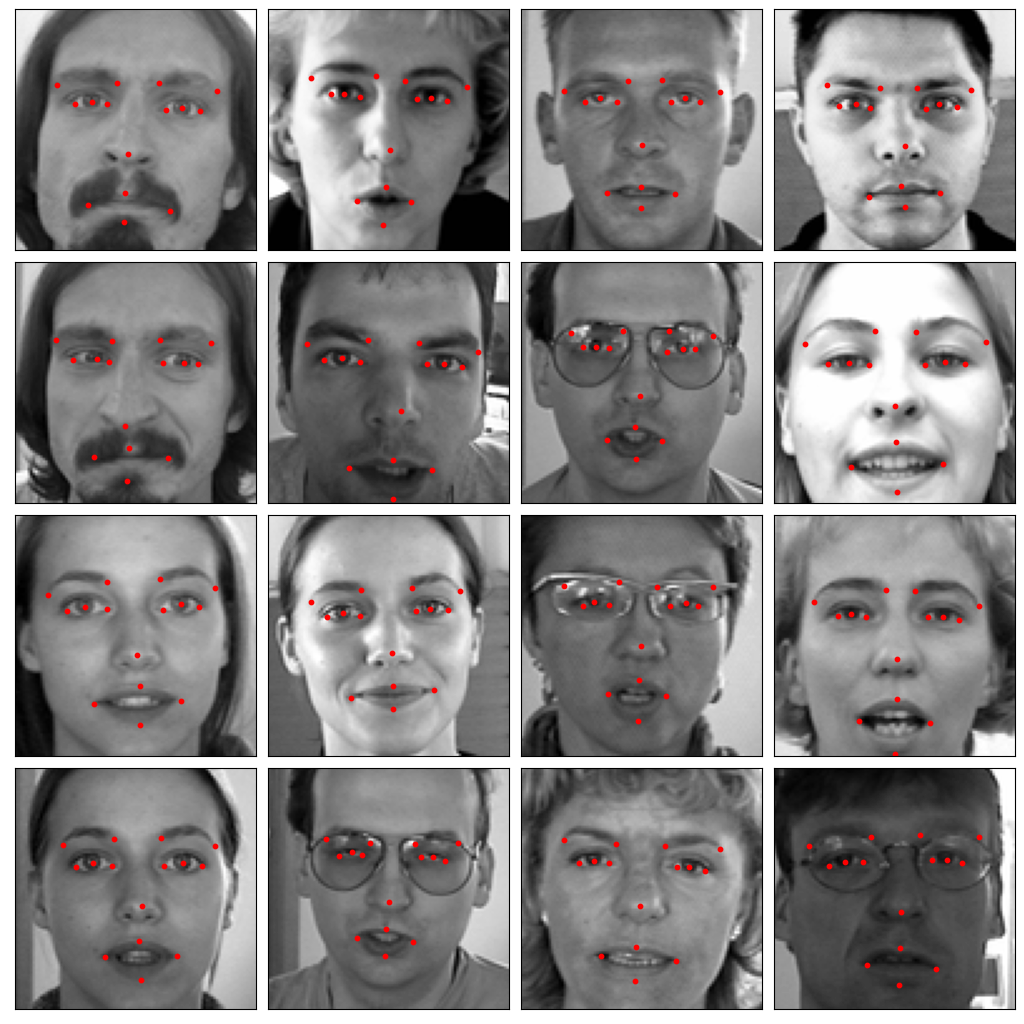

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
from tensorflow.keras import regularizers

# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_cosine_loss(y_pred, y_true, lamda=1.0):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

In [20]:
""" start training """
loss_function = combine_l2_cosine_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 2504.9065  Validation Loss: 1812.4226  Best Validation Loss: 1812.4226
Epoch: 1 . Training Loss: 1822.1272  Validation Loss: 1440.3347  Best Validation Loss: 1440.3347
Epoch: 2 . Training Loss: 1452.7178  Validation Loss: 1297.8176  Best Validation Loss: 1297.8176
Epoch: 3 . Training Loss: 1359.8872  Validation Loss: 1083.5515  Best Validation Loss: 1083.5515
Epoch: 4 . Training Loss: 1056.678  Validation Loss: 977.4999  Best Validation Loss: 977.4999
Epoch: 5 . Training Loss: 992.7655  Validation Loss: 920.6145  Best Validation Loss: 920.6145
Epoch: 6 . Training Loss: 931.50446  Validation Loss: 828.95496  Best Validation Loss: 828.95496
Epoch: 7 . Training Loss: 798.347  Validation Loss: 726.1148  Best Validation Loss: 726.1148
Epoch: 8 . Training Loss: 735.9108  Validation Loss: 661.41235  Best Validation Loss: 661.41235
Epoch: 9 . Training Loss: 654.3918  Validation Loss: 596.57043  Best Validation Loss: 596.57043
Epoch: 10 . Training Loss: 589.3796  Valid

Epoch: 85 . Training Loss: 109.80715  Validation Loss: 116.68309  Best Validation Loss: 116.68309
Epoch: 86 . Training Loss: 91.8879  Validation Loss: 125.67488  Best Validation Loss: 116.68309
Epoch: 87 . Training Loss: 124.81809  Validation Loss: 116.576355  Best Validation Loss: 116.576355
Epoch: 88 . Training Loss: 157.75836  Validation Loss: 134.19547  Best Validation Loss: 116.576355
Epoch: 89 . Training Loss: 119.847694  Validation Loss: 141.36545  Best Validation Loss: 116.576355
Epoch: 90 . Training Loss: 92.2476  Validation Loss: 121.65095  Best Validation Loss: 116.576355
Epoch: 91 . Training Loss: 155.43698  Validation Loss: 130.59344  Best Validation Loss: 116.576355
Epoch: 92 . Training Loss: 133.84027  Validation Loss: 159.9031  Best Validation Loss: 116.576355
Epoch: 93 . Training Loss: 210.1935  Validation Loss: 117.230484  Best Validation Loss: 116.576355
Epoch: 94 . Training Loss: 92.268425  Validation Loss: 119.39604  Best Validation Loss: 116.576355
Epoch: 95 . Tra

Epoch: 168 . Training Loss: 113.299706  Validation Loss: 98.34483  Best Validation Loss: 98.34483
Epoch: 169 . Training Loss: 103.601715  Validation Loss: 103.49678  Best Validation Loss: 98.34483
Epoch: 170 . Training Loss: 73.54131  Validation Loss: 105.585556  Best Validation Loss: 98.34483
Epoch: 171 . Training Loss: 76.9968  Validation Loss: 102.22612  Best Validation Loss: 98.34483
Epoch: 172 . Training Loss: 88.49131  Validation Loss: 99.84359  Best Validation Loss: 98.34483
Epoch: 173 . Training Loss: 88.756165  Validation Loss: 97.327705  Best Validation Loss: 97.327705
Epoch: 174 . Training Loss: 79.71121  Validation Loss: 97.90275  Best Validation Loss: 97.327705
Epoch: 175 . Training Loss: 64.75787  Validation Loss: 97.20105  Best Validation Loss: 97.20105
Epoch: 176 . Training Loss: 97.672356  Validation Loss: 97.06165  Best Validation Loss: 97.06165
Epoch: 177 . Training Loss: 101.3337  Validation Loss: 99.35612  Best Validation Loss: 97.06165
Epoch: 178 . Training Loss: 

### visualization loss

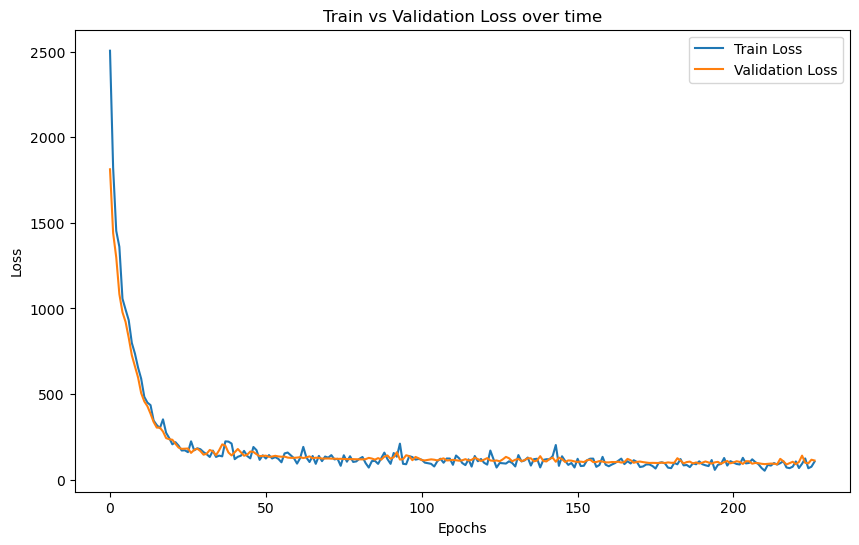

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("Combine L2 And Cosine Error: ", combine_l2_cosine_loss(test_true, test_pred).numpy())

Combine L2 And Cosine Error:  81.39356


### visualize result

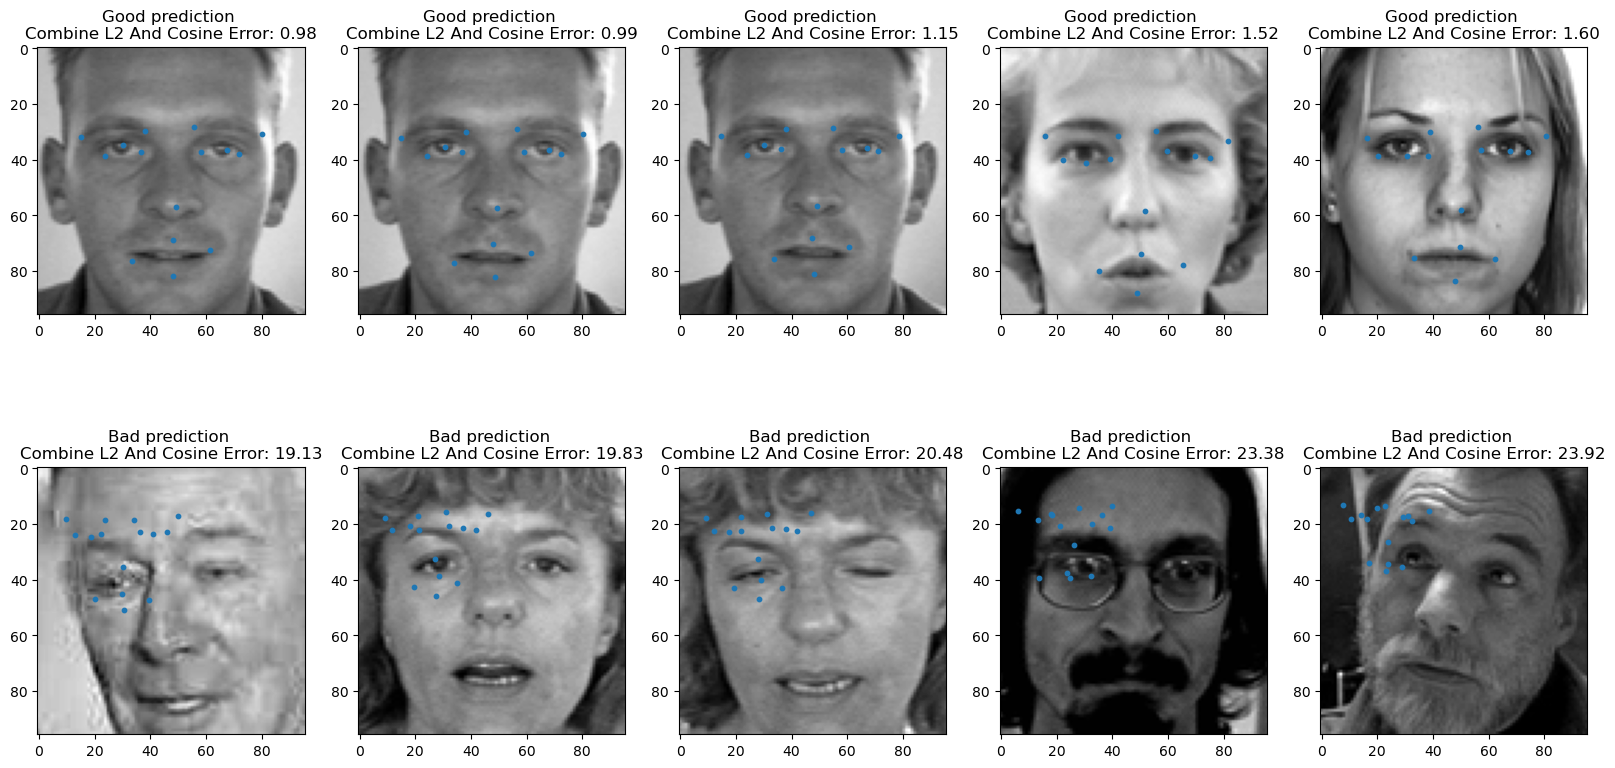

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.abs(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
